In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS, add_constant
from statsmodels.stats.stattools import durbin_watson

In [2]:
data = pd.read_excel("/Users/hetshah/vs code files/ML_project/data/Linear1.xlsx")

In [3]:
data.columns

Index(['DATE', 'DFF', 'USTRADE', 'CPIAUCSL', 'CPALTT01USM657N', 'GFDEBTN',
       'GDP', 'INDPRO', 'M2SL', 'POPTHM', 'UNRATE',
       'Real Estate Loans, All Commercial Banks Daily',
       'Real Personal Consumption Expenditures Daily',
       'Real Government Consumption Expenditures and Gross Investment',
       ' Real Gross Private Domestic Investment',
       'Real Final Sales to Private Domestic Purchasers Daily',
       'Real Disposable Personal Income Daily',
       'Personal Consumption Expenditures-Durable Goods  Daily',
       'Personal Savings Rate Daily',
       'New Privately-Owned Housing Units Started- Total Units Daily',
       'Domestic Nonfinancial Sectors; Debt Securities and Loans; Liability, Level Daily',
       'All Employees, Total Nonfarm Daily',
       'Commercial and Industrial Loans, All Commercial Banks Daily',
       '_Employment-Population Ratio Daily'],
      dtype='object')

In [4]:
print(data.describe())

                      DATE           DFF       USTRADE      CPIAUCSL  \
count                21245  21245.000000  21245.000000  21245.000000   
mean   1995-01-31 00:00:00      4.970108  12634.881805    149.653512   
min    1966-01-01 00:00:00      0.040000   6417.900000     31.880000   
25%    1980-07-17 00:00:00      1.710000  10270.633333     82.909677   
50%    1995-01-31 00:00:00      5.070000  13789.232258    150.887097   
75%    2009-08-16 00:00:00      6.830000  15173.145161    217.275433   
max    2024-03-01 00:00:00     22.360000  15873.600000    312.230000   
std                    NaN      3.816680   2927.136764     77.269418   

       CPALTT01USM657N       GFDEBTN           GDP        INDPRO  \
count     21245.000000  2.124500e+04  21245.000000  21245.000000   
mean          0.327396  7.893054e+06   9468.301903     72.253722   
min          -1.915290  3.160970e+05    795.734000     33.170900   
25%           0.128468  9.116156e+05   2878.930652     50.227200   
50%        

In [5]:
data['DATE'] = pd.factorize(data['DATE'])[0]

In [6]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

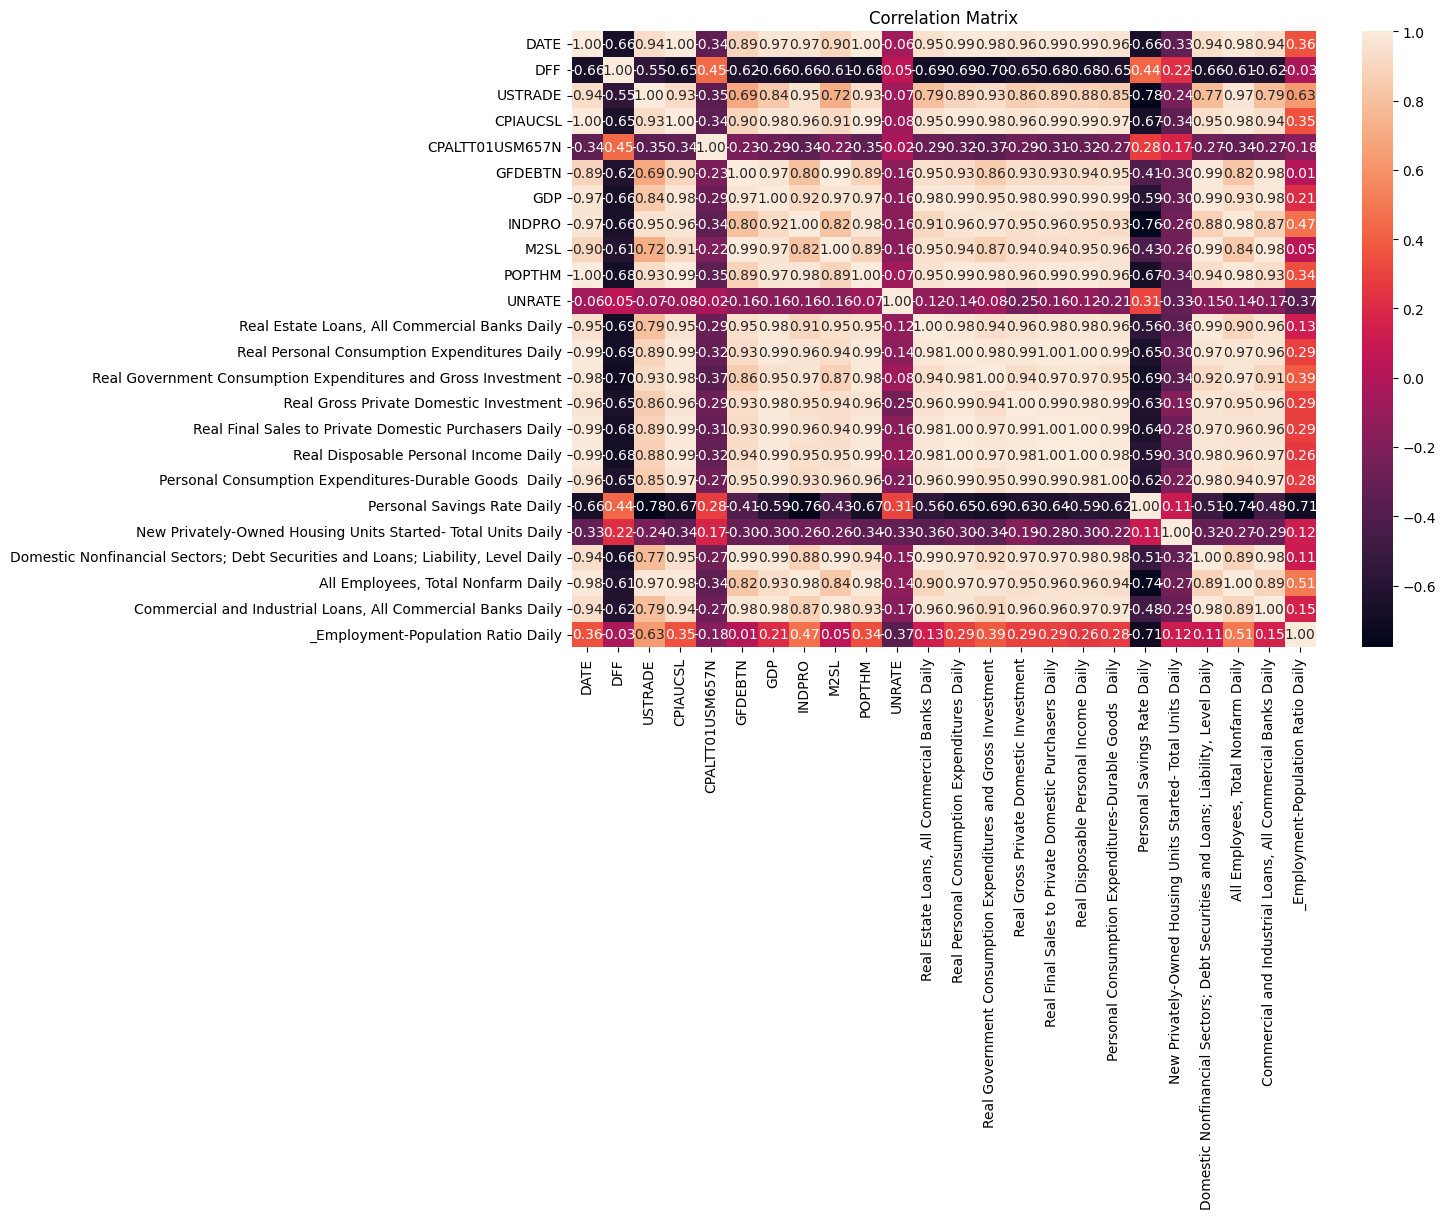

In [7]:
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [8]:
threshold = 0.85

# Drop 'GDP' and 'DATE' columns and rows from the correlation matrix
corr_matrix = correlation_matrix.drop(['GDP', 'DATE'], axis=1).drop(['GDP', 'DATE'], axis=0)

# Mask the upper triangle and diagonal of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
filtered_corr = corr_matrix.where(~mask)

# Filter pairs with absolute correlation above the threshold
high_corr_pairs = filtered_corr[filtered_corr.abs() > threshold].stack().reset_index()

# Rename the columns for better clarity
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Sort by absolute correlation in descending order
high_corr_pairs = high_corr_pairs.reindex(
    high_corr_pairs['Correlation'].abs().sort_values(ascending=False).index
)

# Extract unique features involved in the highly correlated pairs
selected_features = set(high_corr_pairs['Feature 1']).union(set(high_corr_pairs['Feature 2']))

# Print the result
if not high_corr_pairs.empty:
    print(f"Highly correlated feature pairs (threshold: {threshold}):")
    print(high_corr_pairs)
    print("\nList of selected features based on high correlation:")
    print(sorted(selected_features))
else:
    print(f"No feature pairs with correlation above {threshold}.")
    print("\nNo features selected.")


Highly correlated feature pairs (threshold: 0.85):
                                            Feature 1  \
47  Real Final Sales to Private Domestic Purchaser...   
57              Real Disposable Personal Income Daily   
60              Real Disposable Personal Income Daily   
5                                                M2SL   
7                                              POPTHM   
..                                                ...   
27  Real Government Consumption Expenditures and G...   
99  Commercial and Industrial Loans, All Commercia...   
31             Real Gross Private Domestic Investment   
25  Real Government Consumption Expenditures and G...   
61  Personal Consumption Expenditures-Durable Good...   

                                            Feature 2  Correlation  
47       Real Personal Consumption Expenditures Daily     0.999422  
57       Real Personal Consumption Expenditures Daily     0.996760  
60  Real Final Sales to Private Domestic Purchaser...    

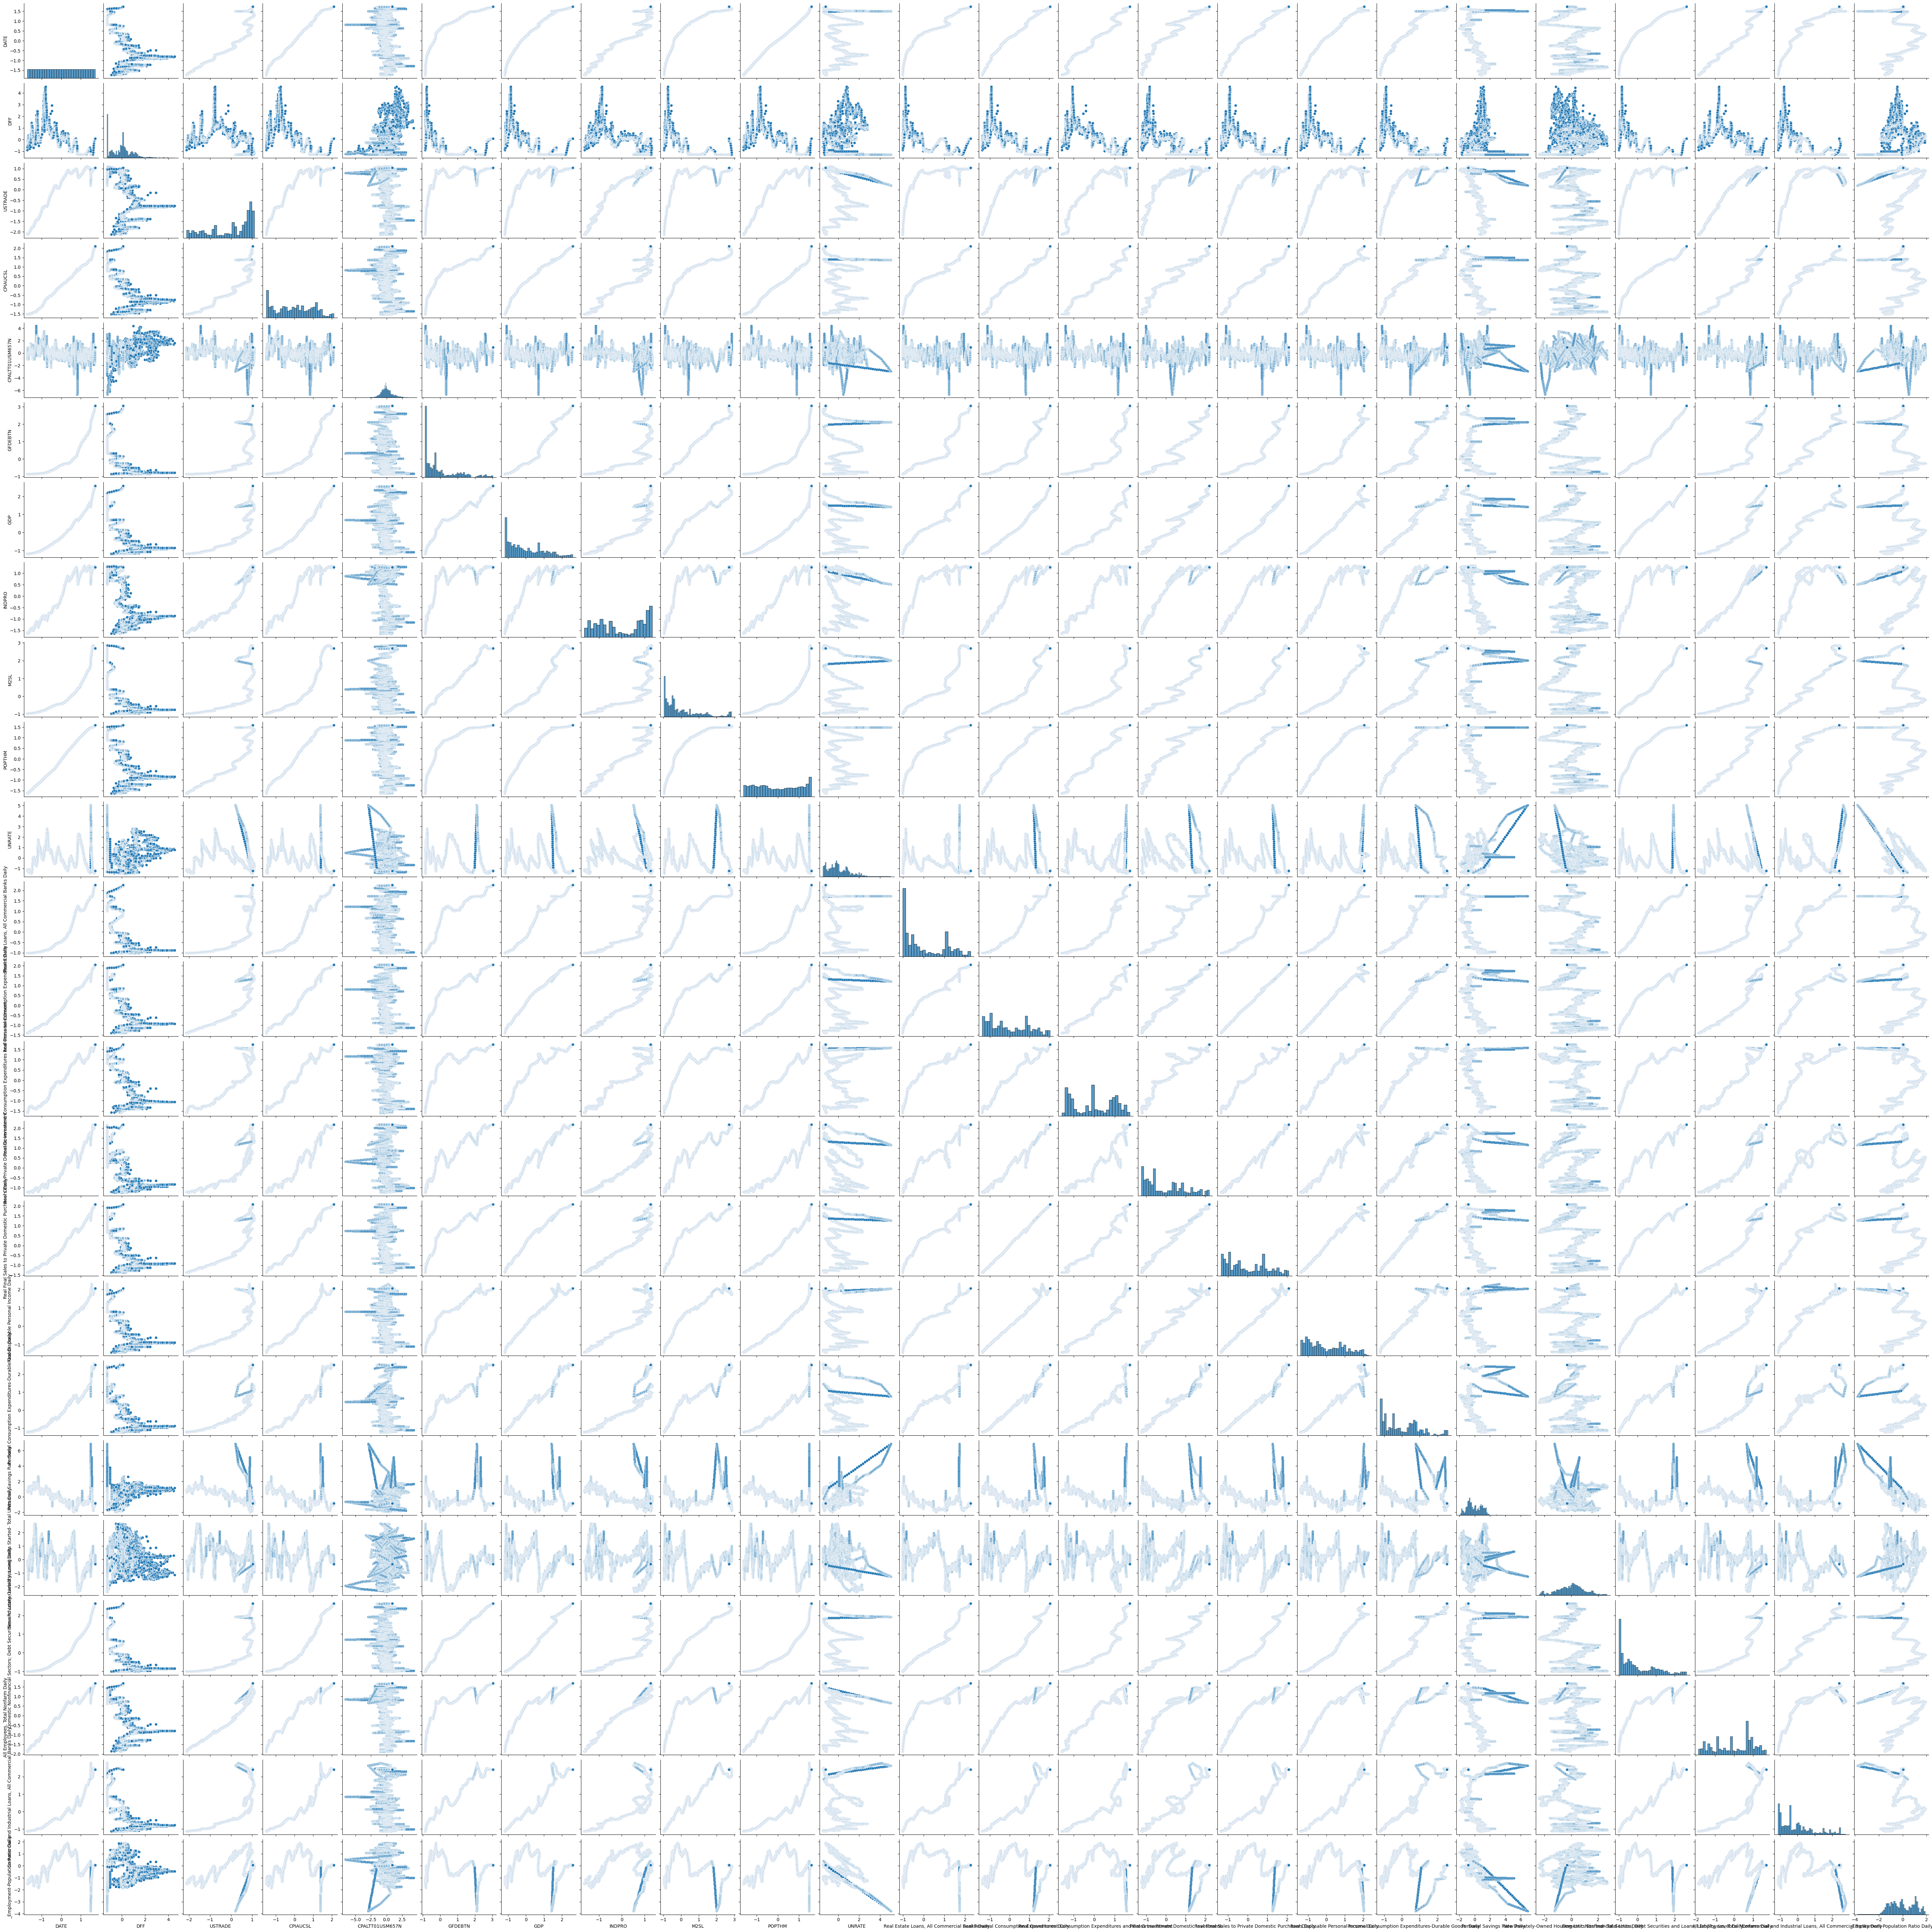

In [9]:
sns.pairplot(data)
plt.show()


In [10]:


def pesaran_timmerman_feature_selection(data, target_column, significance_level=0.05):
    """
    Perform feature selection using Pesaran-Timmerman predictive regression.
    
    Parameters:
        data (pd.DataFrame): DataFrame with features and target variable.
        target_column (str): Name of the target column.
        significance_level (float): Threshold for feature significance (default=0.05).
    
    Returns:
        selected_features (list): List of selected features based on predictive regression.
        feature_statistics (pd.DataFrame): Summary statistics for all features.
    """
    target = data[target_column]
    features = data.drop(columns=[target_column])
    
    selected_features = []
    stats = []
    
    for feature in features.columns:
        X = add_constant(features[feature])  # Add intercept
        model = OLS(target, X).fit()
        p_value = model.pvalues[1]  # P-value for the feature
        t_stat = model.tvalues[1]   # T-statistic for the feature
        
        stats.append({
            'Feature': feature,
            'T-Statistic': t_stat,
            'P-Value': p_value,
            'DW-Statistic': durbin_watson(model.resid)
        })
        
        if p_value < significance_level:
            selected_features.append(feature)
    
    feature_statistics = pd.DataFrame(stats)
    return selected_features, feature_statistics


target_column = 'GDP'
significance_level = 0.05

selected_features, feature_statistics = pesaran_timmerman_feature_selection(data, target_column, significance_level)

print("Selected Features:")
print(selected_features)

print("\nFeature Statistics:")
print(feature_statistics)


Selected Features:
['DATE', 'DFF', 'USTRADE', 'CPIAUCSL', 'CPALTT01USM657N', 'GFDEBTN', 'INDPRO', 'M2SL', 'POPTHM', 'UNRATE', 'Real Estate Loans, All Commercial Banks Daily', 'Real Personal Consumption Expenditures Daily', 'Real Government Consumption Expenditures and Gross Investment', ' Real Gross Private Domestic Investment', 'Real Final Sales to Private Domestic Purchasers Daily', 'Real Disposable Personal Income Daily', 'Personal Consumption Expenditures-Durable Goods  Daily', 'Personal Savings Rate Daily', 'New Privately-Owned Housing Units Started- Total Units Daily', 'Domestic Nonfinancial Sectors; Debt Securities and Loans; Liability, Level Daily', 'All Employees, Total Nonfarm Daily', 'Commercial and Industrial Loans, All Commercial Banks Daily', '_Employment-Population Ratio Daily']

Feature Statistics:
                                              Feature  T-Statistic  \
0                                                DATE   574.451685   
1                                 

/var/folders/xk/107v4z4d7xj_vvtz9zltk8_m0000gn/T/ipykernel_5326/1046397510.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = model.pvalues[1]  # P-value for the feature
/var/folders/xk/107v4z4d7xj_vvtz9zltk8_m0000gn/T/ipykernel_5326/1046397510.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stat = model.tvalues[1]   # T-statistic for the feature
/var/folders/xk/107v4z4d7xj_vvtz9zltk8_m0000gn/T/ipykernel_5326/1046397510.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [11]:
feature_statistics

Feature  T-Statistic  \
0                                                DATE   574.451685   
1                                                 DFF  -129.345541   
2                                             USTRADE   222.759041   
3                                            CPIAUCSL   654.841216   
4                                     CPALTT01USM657N   -44.251653   
5                                             GFDEBTN   554.425727   
6                                              INDPRO   350.276228   
7                                                M2SL   599.940896   
8                                              POPTHM   567.192994   
9                                              UNRATE   -24.109806   
10      Real Estate Loans, All Commercial Banks Daily   819.263942   
11       Real Personal Consumption Expenditures Daily  1089.319656   
12  Real Government Consumption Expenditures and G...   448.278554   
13             Real Gross Private Domestic Investment   808.844254   
14  Real Final Sales to Private Domestic Purchaser...  1116.981192   
15              Real Disposable Personal Income Daily  1065.538247   
16  Personal Consumption Expenditures-Durable Good...  1052.359182   
17                        Personal Savings Rate Daily  -105.896370   
18  New Privately-Owned Housing Units Started- Tot...   -46.460610   
19  Domestic Nonfinancial Sectors; Debt Securities...  1208.124631   
20                 All Employees, Total Nonfarm Daily   378.659096   
21  Commercial and Industrial Loans, All Commercia...   733.108023   
22                 _Employment-Population Ratio Daily    31.248833   

          P-Value  DW-Statistic  
0    0.000000e+00      0.000002  
1    0.000000e+00      0.005333  
2    0.000000e+00      0.000002  
3    0.000000e+00      0.000002  
4    0.000000e+00      0.000096  
5    0.000000e+00      0.000004  
6    0.000000e+00      0.000005  
7    0.000000e+00      0.000004  
8    0.000000e+00      0.000002  
9   9.931240e-127      0.000002  
10   0.000000e+00      0.000005  
11   0.000000e+00      0.000002  
12   0.000000e+00      0.000003  
13   0.000000e+00      0.000011  
14   0.000000e+00      0.000002  
15   0.000000e+00      0.000030  
16   0.000000e+00      0.000114  
17   0.000000e+00      0.000090  
18   0.000000e+00      0.000010  
19   0.000000e+00      0.000009  
20   0.000000e+00      0.000005  
21   0.000000e+00      0.000028  
22  1.269275e-209      0.000001